In [1]:
import os
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torch.optim as optim
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from tqdm import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
path = "/kaggle/input/paddydoctor"

In [3]:
IMG_SIZE = (384,384)

In [4]:
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE,antialias=True),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.45, 0.43, 0.40], std=[0.24, 0.24, 0.24]),
])

In [5]:
dataset = ImageFolder(path,transform)

In [6]:
diseases = dataset.classes
diseases

['bacterial_leaf_blight',
 'bacterial_leaf_streak',
 'bacterial_panicle_blight',
 'black_stem_borer',
 'blast',
 'brown_spot',
 'downy_mildew',
 'hispa',
 'leaf_roller',
 'normal',
 'tungro',
 'white_stem_borer',
 'yellow_stem_borer']

In [7]:
def show_random():
  idx = np.random.randint(0,len(dataset),(4))
  plt.figure(figsize=(10,10))
  for i in range(4):
    plt.subplot(2,2,i+1)
    img = dataset[idx[i]]
    plt.imshow(img[0].permute(1,2,0))
    plt.title(diseases[img[1]])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

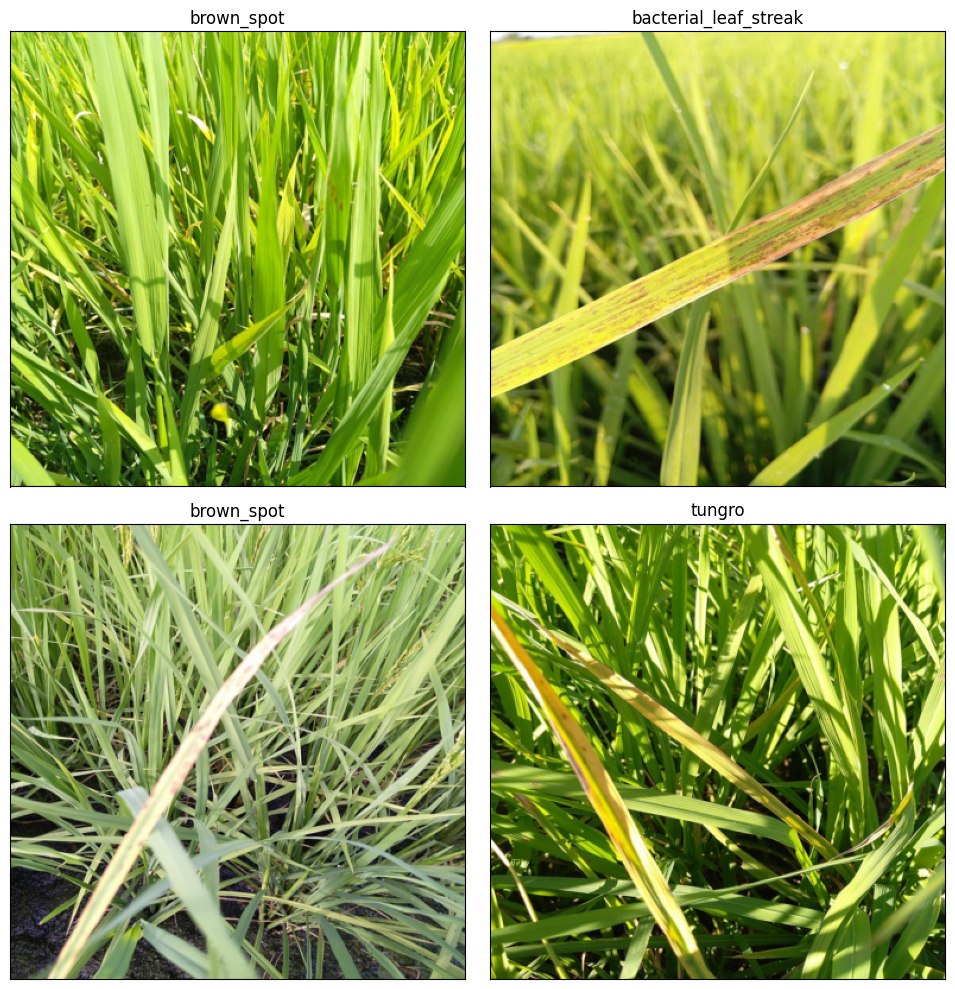

In [8]:
show_random()

In [9]:
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])

In [10]:
BATCH_SIZE = 16

In [11]:
train_loader =  DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader =  DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [12]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights=None)
model = model.eval()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip


In [13]:
num_ftrs = model.fc.in_features
num_ftrs

2048

In [14]:
len(diseases)

13

In [15]:
model.fc = nn.Linear(num_ftrs,len(diseases))

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
checkpoint = torch.load("/kaggle/input/paddy-midterm/model_res50.pth",map_location=torch.device("cpu"))

In [18]:
def train(model,EPOCHS,train_loader,val_loader, lr = 0.001,exp_name=""):
    writer = SummaryWriter(f"runs/{exp_name}")

    batch_n = len(train_loader)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model = model.to(device)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    criterion = checkpoint['loss']
    
    train_acc = []
    train_loss = []
    val_loss = [99]
    val_acc = [0]

    for epoch in range(EPOCHS):
        model.train(True)
        pbar = tqdm(train_loader)

        batch_loss = []
        batch_acc = []

        for i,data in enumerate(pbar):
            inputs,labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # Make predictions for this batch
            outputs = model(inputs)
            acc = (labels == outputs.argmax(dim=-1)).float().mean().item()
            # Compute the loss and its gradients
            loss = criterion(outputs, labels)
            loss.backward()

            batch_loss.append(loss.item())
            batch_acc.append(acc)
            # Adjust learning weights
            optimizer.step()

            pbar.set_description(f"Epoch: {epoch + 1}/{EPOCHS}; Train Loss: {round(np.mean(batch_loss),3)}; Train Acc: {round(np.mean(batch_acc),3)};\
            Val Loss: {round(np.mean(val_loss),3)}; Val Acc: {round(np.mean(val_acc),3)}")

          # Set the model to evaluation mode, disabling dropout and using population
          # statistics for batch normalization.
        torch.save({
            'epoch': EPOCHS,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, 'model_res50.pth')
        model.eval()
        model.eval()
        # Disable gradient computation and reduce memory consumption.
        with torch.no_grad():
            val_batch_loss = []
            val_batch_acc = []
            for i, vdata in enumerate(val_loader):
                vinputs, vlabels = vdata
                vinputs = vinputs.to(device)
                vlabels = vlabels.to(device)
                voutputs = model(vinputs)
                test_acc = (vlabels == voutputs.argmax(dim=-1)).float().mean().item()
                vloss = criterion(voutputs, vlabels).item()

                val_batch_loss.append(vloss)
                val_batch_acc.append(test_acc)

        val_loss.append(np.mean(val_batch_loss))
        val_acc.append(np.mean(val_batch_acc))
        train_acc.append(np.mean(batch_acc))
        train_loss.append(np.mean(batch_loss))

        writer.add_scalars(exp_name+"/Train vs Val/loss", {"train":train_loss[-1],"val":val_loss[-1]}, epoch)
        writer.add_scalars(exp_name+"/Train vs Val/accuracy", {"train":train_acc[-1],"val":val_acc[-1]}, epoch)


    writer.add_hparams({"lr":0.001,"batch_size":BATCH_SIZE},
     {"train_loss":train_loss[-1],"val_loss":val_loss[-1],"train_acc":train_acc[-1],"val_acc":val_acc[-1]})
    return train_acc,train_loss,val_acc,val_loss

In [19]:
EPOCHS = 40

In [20]:
EXP_NAME = "Resnet50-imgnet"

In [21]:
train_acc,train_loss,val_acc,val_loss = train(model,EPOCHS,train_loader,val_loader,lr=1e-4,exp_name=EXP_NAME)

Epoch: 1/40; Train Loss: 0.094; Train Acc: 0.976;            Val Loss: 99.0; Val Acc: 0.0: 100%|██████████| 812/812 [09:05<00:00,  1.49it/s]
Epoch: 2/40; Train Loss: 0.03; Train Acc: 0.992;            Val Loss: 49.539; Val Acc: 0.492: 100%|██████████| 812/812 [08:02<00:00,  1.68it/s]
Epoch: 3/40; Train Loss: 0.034; Train Acc: 0.99;            Val Loss: 33.049; Val Acc: 0.657: 100%|██████████| 812/812 [08:02<00:00,  1.68it/s]
Epoch: 4/40; Train Loss: 0.042; Train Acc: 0.988;            Val Loss: 24.828; Val Acc: 0.733: 100%|██████████| 812/812 [08:03<00:00,  1.68it/s]
Epoch: 5/40; Train Loss: 0.031; Train Acc: 0.991;            Val Loss: 19.88; Val Acc: 0.783: 100%|██████████| 812/812 [07:59<00:00,  1.69it/s]
Epoch: 6/40; Train Loss: 0.029; Train Acc: 0.991;            Val Loss: 16.578; Val Acc: 0.817: 100%|██████████| 812/812 [08:09<00:00,  1.66it/s]
Epoch: 7/40; Train Loss: 0.017; Train Acc: 0.994;            Val Loss: 14.223; Val Acc: 0.84: 100%|██████████| 812/812 [07:53<00:00,  1.7

In [22]:
# torch.save(model.state_dict(), "paddy_resnet50-30epochs_pre.pt") 

In [23]:
!cp runs/{EXP_NAME} "/content/drive/MyDrive/Colab Notebooks/Paddy/Logs"

cp: -r not specified; omitting directory 'runs/Resnet50-imgnet'


In [24]:
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix, ConfusionMatrixDisplay

In [25]:
def evaluate_model(model,data_loader,ds=""):
    # we can now evaluate the network on the test set
    print(f"[INFO] evaluating network on {ds} set...")
    # turn off autograd for testing evaluation
    with torch.no_grad():
        # set the model in evaluation mode
        model.eval()

        # initialize a list to store our predictions
        preds = []
        true = []
        # loop over the test set
        pbar = tqdm(data_loader)
        for (x, y) in pbar:
            # send the input to the device
            x = x.to(device)
            # make the predictions and add them to the list
            true.extend(y.cpu().tolist())
            pred = model(x)
            preds.extend(pred.argmax(axis=1).cpu().tolist())
    # generate a classification report
    print(classification_report(true,
        preds, target_names=diseases))
    print(f"{ds} Accuracy: ",accuracy_score(true,preds))
    return true,preds

    # plt.rcParams.update({'font.size': 8})
    # cm = confusion_matrix(true, preds)
    # ax = plt.subplot()
    # sns.heatmap(cm,annot=True,fmt="g")
    # ax.set_xlabel('Predicted labels')
    # ax.set_ylabel('True labels')
    # ax.set_title(f'Confusion Matrix-{ds} Set',fontsize=10)
    # ax.xaxis.set_ticklabels(diseases,rotation=90,fontsize=7)
    # ax.yaxis.set_ticklabels(diseases,rotation=0,fontsize=7)
    # plt.show()

In [26]:
oo1 = evaluate_model(model,train_loader,ds="train")

[INFO] evaluating network on train set...


100%|██████████| 812/812 [05:46<00:00,  2.34it/s]

                          precision    recall  f1-score   support

   bacterial_leaf_blight       1.00      1.00      1.00       514
   bacterial_leaf_streak       1.00      1.00      1.00       399
bacterial_panicle_blight       0.99      1.00      0.99       363
        black_stem_borer       1.00      1.00      1.00       405
                   blast       1.00      1.00      1.00      1886
              brown_spot       1.00      1.00      1.00      1001
            downy_mildew       1.00      1.00      1.00       675
                   hispa       1.00      1.00      1.00      1727
             leaf_roller       1.00      1.00      1.00       885
                  normal       1.00      1.00      1.00      1939
                  tungro       1.00      1.00      1.00      1549
        white_stem_borer       1.00      1.00      1.00      1017
       yellow_stem_borer       1.00      1.00      1.00       620

                accuracy                           1.00     12980
        

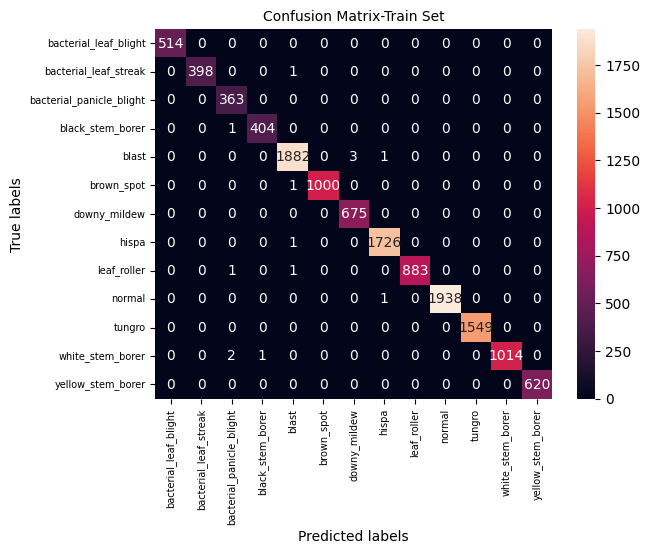

In [27]:
cm = confusion_matrix(oo1[0], oo1[1])
ax = plt.subplot()
sns.heatmap(cm,annot=True,fmt="g")
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix-Train Set',fontsize=10)
ax.xaxis.set_ticklabels(diseases,rotation=90,fontsize=7)
ax.yaxis.set_ticklabels(diseases,rotation=0,fontsize=7)

plt.show()

In [28]:
oo2 = evaluate_model(model,val_loader,ds="Validation")

[INFO] evaluating network on Validation set...


100%|██████████| 203/203 [01:24<00:00,  2.40it/s]

                          precision    recall  f1-score   support

   bacterial_leaf_blight       0.98      0.96      0.97       134
   bacterial_leaf_streak       0.98      0.98      0.98       106
bacterial_panicle_blight       0.93      1.00      0.96        87
        black_stem_borer       0.98      0.98      0.98       101
                   blast       0.95      0.99      0.97       465
              brown_spot       0.96      0.97      0.97       256
            downy_mildew       0.97      0.96      0.97       193
                   hispa       0.99      0.97      0.98       424
             leaf_roller       0.97      0.96      0.96       210
                  normal       0.99      0.99      0.99       466
                  tungro       0.99      0.99      0.99       402
        white_stem_borer       0.99      0.96      0.97       256
       yellow_stem_borer       0.98      0.99      0.98       145

                accuracy                           0.98      3245
        

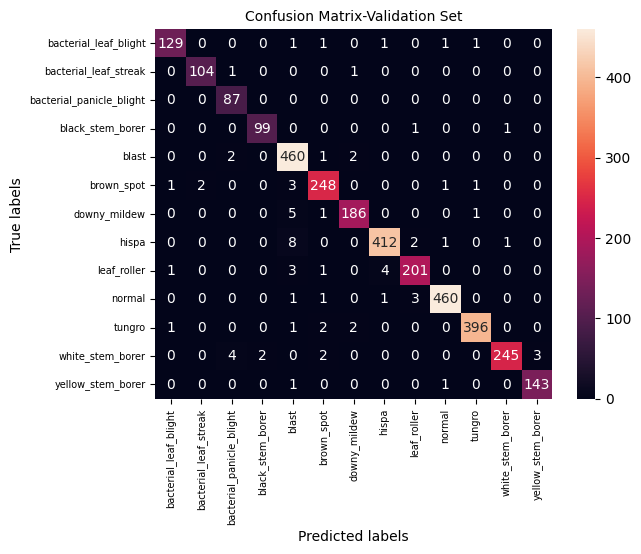

In [29]:
cm = confusion_matrix(oo2[0], oo2[1])
ax = plt.subplot()
sns.heatmap(cm,annot=True,fmt="g")
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix-Validation Set',fontsize=10)
ax.xaxis.set_ticklabels(diseases,rotation=90,fontsize=7)
ax.yaxis.set_ticklabels(diseases,rotation=0,fontsize=7)

plt.show()

In [30]:
from torchvision.io import read_image

In [31]:
transform2 = transforms.Compose([
    transforms.ToPILImage(),
#     transforms.Resize((256,256),antialias=True),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.45, 0.43, 0.40], std=[0.24, 0.24, 0.24]),
])

In [32]:
def myPred(path):
    im = read_image(path)
    im = transform2(im).unsqueeze(0).cuda()
    pred = model(im)
    dis = diseases[pred.argmax().tolist()]
    print(dis)

In [33]:
!wget "https://content.peat-cloud.com/w600/bacterial-blight-of-rice-rice-1581498605.jpg" -O p.jpg

--2024-02-21 00:10:27--  https://content.peat-cloud.com/w600/bacterial-blight-of-rice-rice-1581498605.jpg
Resolving content.peat-cloud.com (content.peat-cloud.com)... 18.164.78.105, 18.164.78.13, 18.164.78.122, ...
Connecting to content.peat-cloud.com (content.peat-cloud.com)|18.164.78.105|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 83862 (82K) [image/jpeg]
Saving to: ‘p.jpg’

p.jpg               100%[===================>]  81.90K   442KB/s    in 0.2s    

2024-02-21 00:10:27 (442 KB/s) - ‘p.jpg’ saved [83862/83862]



In [34]:
myPred("p.jpg")

blast


In [35]:
myPred(path+"/brown_spot/PDD04463.jpg")

brown_spot


In [36]:
%load_ext tensorboard
%tensorboard --logdir runs